In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

# データの確認・可視化

In [3]:
#データのインポート
data = pd.read_csv('./train.csv', index_col='datetime', parse_dates=True)
data.head()

,y,client,close,price_am,price_pm
datetime,,,,,
2010-07-01,17,0,0,-1,-1
2010-07-02,18,0,0,-1,-1
2010-07-03,20,0,0,-1,-1
2010-07-04,20,0,0,-1,-1
2010-07-05,14,0,0,-1,-1


In [4]:
data.shape

(2101, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2101 entries, 2010-07-01 to 2016-03-31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   y         2101 non-null   int64
 1   client    2101 non-null   int64
 2   close     2101 non-null   int64
 3   price_am  2101 non-null   int64
 4   price_pm  2101 non-null   int64
dtypes: int64(5)
memory usage: 98.5 KB


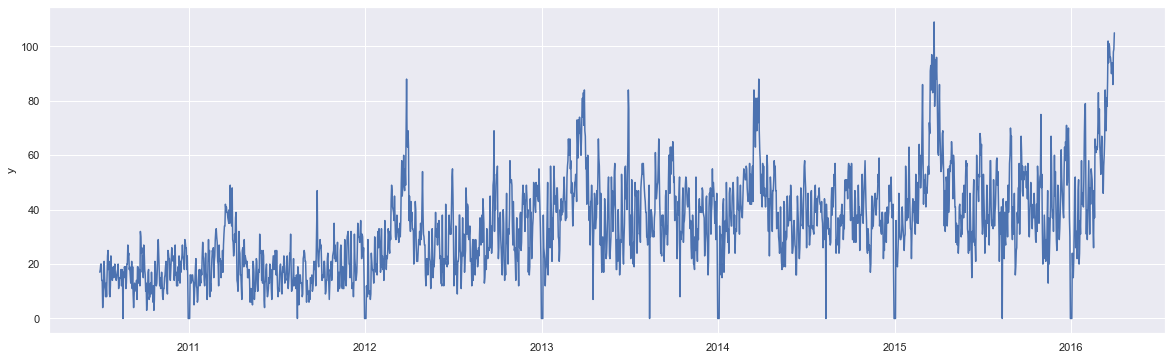

In [7]:
#各特徴量毎に時系列順にプロットしてみる
plt.figure(figsize=(20,6))
plt.plot(data['y'])
plt.ylabel('y')
plt.show()

yには長期的なトレンド、季節性があることが見て取れる

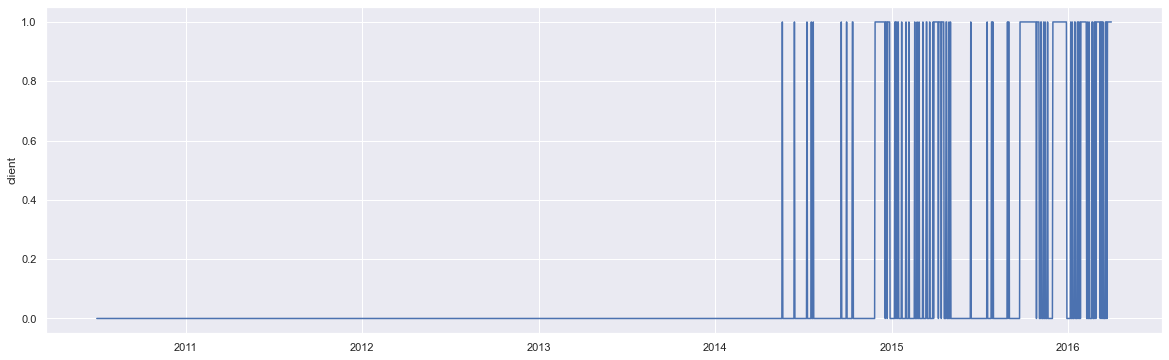

In [8]:
plt.figure(figsize=(20,6))
plt.plot(data['client'])
plt.ylabel('client')
plt.show()

client(法人利用日)は2014年半ば頃から発生している

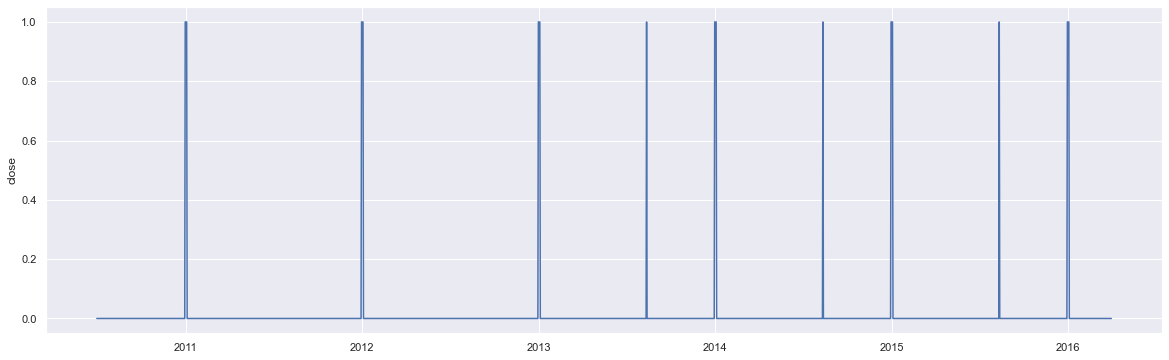

In [9]:
plt.figure(figsize=(20,6))
plt.plot(data['close'])
plt.ylabel('close')
plt.show()

close（休業日）は、年末年始に数日間ある。また2013年から夏季休暇を導入したことが見て取れる

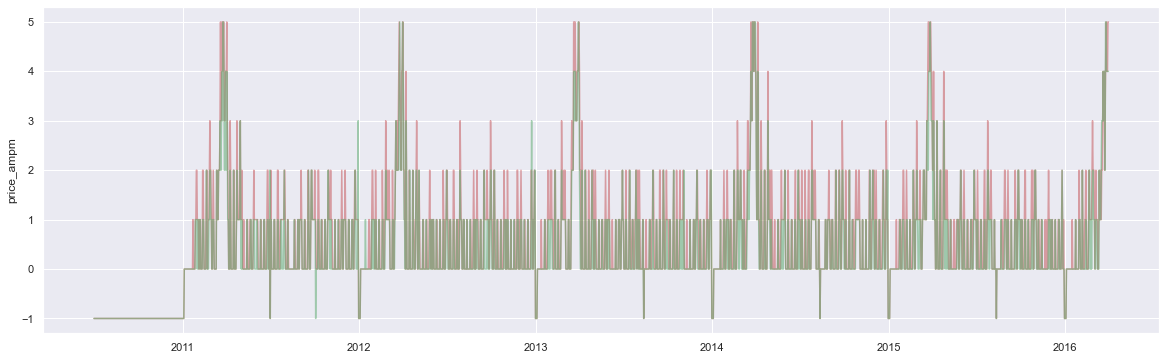

In [10]:
plt.figure(figsize=(20,6))
plt.plot(data['price_am'], c='r', alpha=0.5)
plt.plot(data['price_pm'], c='g', alpha=0.5)
plt.ylabel('price_ampm')
plt.show()

料金区分には一定の周期性が見て取れる。おそらく、繁忙期（3月4月）は料金を高く設定しているのだろう\
またam,pmがおおむね重なっていることから、一日の料金区分はそこまで変動しないと思われる。\
price_am、price_pmで特徴量を分ける必要はない？？

## 欠損値の解釈

price_am, price_pmには2010年において、データがすべて-1となっていることが確認できた。\
price_am, price_pmとcloseの関係を見てみると、休業日にprice_am,pmが-1になっていると思われる。\
以上のことから、2010年のprice_am,pmの値は欠損データだと判断する。\
欠測メカニズムとしては、MARが妥当。

## 自己相関係数と偏自己相関係数を可視化する

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


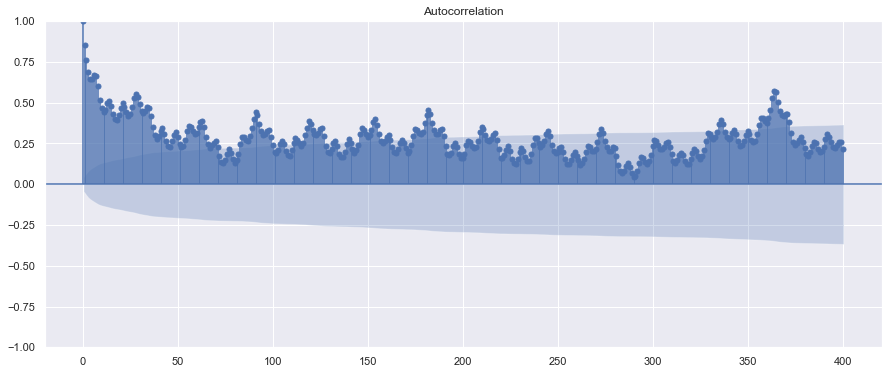

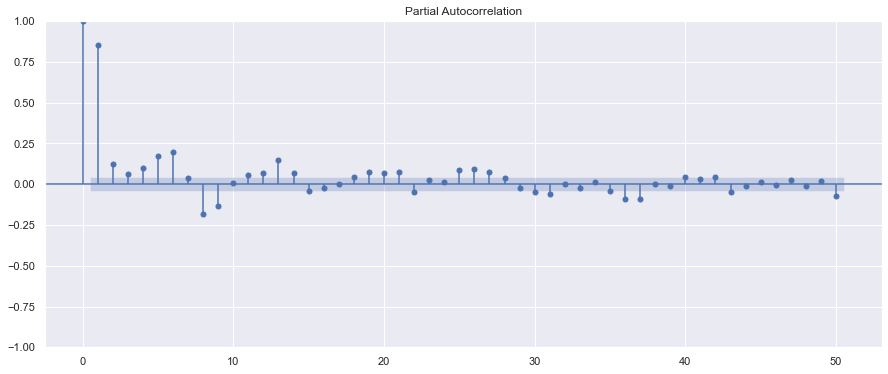

In [11]:
fig_1 = sm.graphics.tsa.plot_acf(data['y'], lags=400)
fig_2 = sm.graphics.tsa.plot_pacf(data['y'], lags=50)

## 波状分解してみる

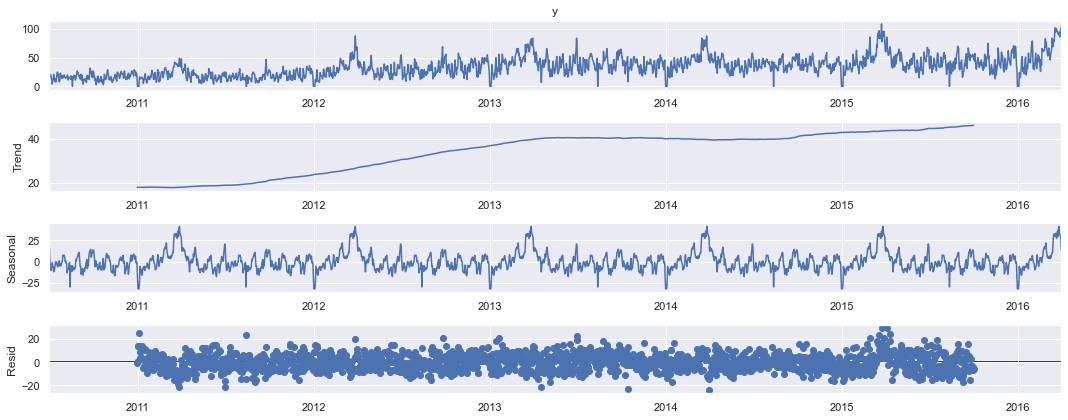

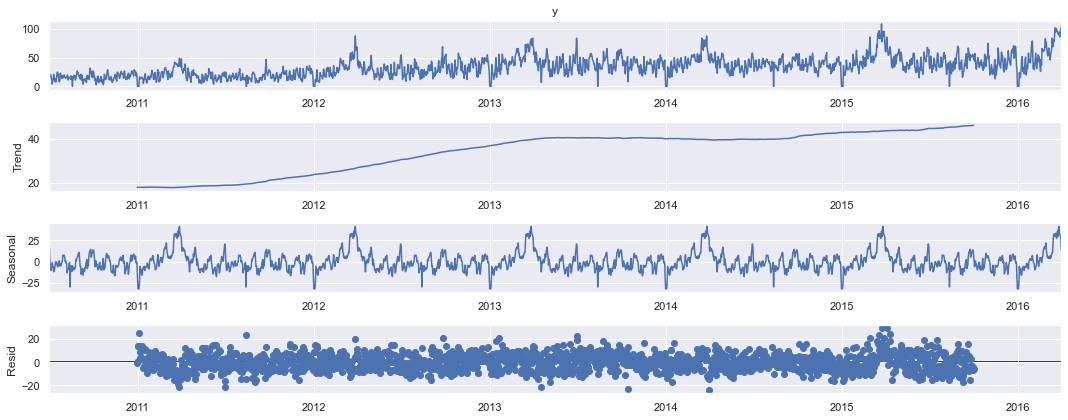

In [12]:
result = seasonal_decompose(data['y'], period=365, two_sided=True)
result.plot()

# ベースラインモデルを作成する

In [16]:
ts = data['y']

In [19]:
ts['2015-04-01':'2016-03-31']

datetime
2015-04-01     61
2015-04-02     60
2015-04-03     75
2015-04-04     86
2015-04-05     69
             ... 
2016-03-27     94
2016-03-28     86
2016-03-29     98
2016-03-30     99
2016-03-31    105
Name: y, Length: 366, dtype: int64

In [22]:
#訓練データと検証データに分割
train_data = ts[:'2015-03-31']
test_data = ts['2015-04-01':]

In [23]:
sarima_model = sm.tsa.SARIMAX(train_data, order=(4,1,1), seasonal_order=(2,1,3,365))
result = sarima_model.fit()

result.summary()

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
best_pred = result.predict(start='2015-04-01', end='2016-04-01')
plt.plot(ts)
plt.plot(best_pred, c='red')

AttributeError: 'DecomposeResult' object has no attribute 'predict'